# Install Required Packages

In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
import requests
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('words')
stop_words = stopwords.words('english')
words = set(nltk.corpus.words.words())
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Connect to google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data visualization

Path to Train and test datasets

In [3]:
path_to_test_file = "/content/gdrive/MyDrive/TEST_FILE.txt"
path_to_file = "/content/gdrive/MyDrive/TRAIN_FILE.TXT"

Data loader

In [4]:
def load_data_label(path):
    temp_data = []
    lines = [line.strip() for line in open(path)]
    for idx in range(0, len(lines), 4):
        id = lines[idx].split("\t")[0]
        relation = lines[idx + 1]

        sentence = lines[idx].split("\t")[1][1:-1]
        sentence = sentence.replace("<e1>", " _e1_ ").replace("</e1>", " _/e1_ ")
        sentence = sentence.replace("<e2>", " _e2_ ").replace("</e2>", " _/e2_ ")
        sentence = sentence.replace("<e1>", "<e1> ").replace("</e1>", " </e11>")
        sentence = sentence.replace("<e2>", "<e2> ").replace("</e2>", " </e22>")

        tokens = nltk.word_tokenize(sentence)
        
        tokens.remove('_/e1_')
        tokens.remove('_/e2_')
        
        e1 = tokens.index("_e1_")
        del tokens[e1]
        element1=tokens[e1]
        e2 = tokens.index("_e2_")
        del tokens[e2]
        element2=tokens[e2]
        sentence = " ".join(tokens)
        temp_data.append([id, sentence, e1, element1, e2, element2, relation])
    df = pd.DataFrame(data=temp_data, columns=["id", "sentence", "e1_position","element1", "e2_position","element2", "class"])
    #print (df)
    labelsMapping = {'Other': 0,'Message-Topic(e1,e2)': 1, 'Message-Topic(e2,e1)': 2,
                    'Product-Producer(e1,e2)': 3, 'Product-Producer(e2,e1)': 4,
                    'Instrument-Agency(e1,e2)': 5, 'Instrument-Agency(e2,e1)': 6,
                    'Entity-Destination(e1,e2)': 7, 'Entity-Destination(e2,e1)': 8,
                    'Cause-Effect(e1,e2)': 9, 'Cause-Effect(e2,e1)': 10,
                    'Component-Whole(e1,e2)': 11, 'Component-Whole(e2,e1)': 12,
                    'Entity-Origin(e1,e2)': 13, 'Entity-Origin(e2,e1)': 14,
                    'Member-Collection(e1,e2)': 15, 'Member-Collection(e2,e1)': 16,
                    'Content-Container(e1,e2)': 17, 'Content-Container(e2,e1)': 18}
    df['tag'] = [labelsMapping[r] for r in df['class']]
    #print(df)
    x_sentence = df['sentence'].tolist()

    #Label Data
    y = df['tag']
    return df

In [5]:
df=load_data_label(path_to_file)
df_test = load_data_label(path_to_test_file)
df

,id,sentence,e1_position,element1,e2_position,element2,class,tag
0,1,The system as described above has its greatest...,12,configuration,15,elements,"Component-Whole(e2,e1)",12
1,2,The child was carefully wrapped and bound into...,1,child,9,cradle,Other,0
2,3,The author of a keygen uses a disassembler to ...,1,author,7,disassembler,"Instrument-Agency(e2,e1)",6
3,4,A misty ridge uprises from the surge .,2,ridge,6,surge,Other,0
4,5,The student association is the voice of the un...,1,student,2,association,"Member-Collection(e1,e2)",15
...,...,...,...,...,...,...,...,...
7995,7996,"When the notice is sent by fax , the notice is...",2,notice,6,fax,Other,0
7996,7997,The herbicide is derived from a natural antibi...,1,herbicide,7,antibiotic,"Entity-Origin(e1,e2)",13
7997,7998,"To test this , we placed a kitchen match in th...",8,match,11,jar,"Entity-Destination(e1,e2)",7
7998,7999,The farmers and city officials in the region h...,17,farmers,18,market,Other,0


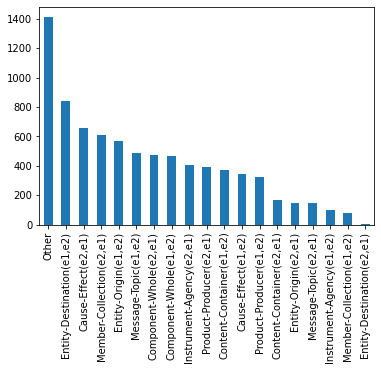

In [6]:
df['class'].value_counts()[:27].plot(kind='bar')

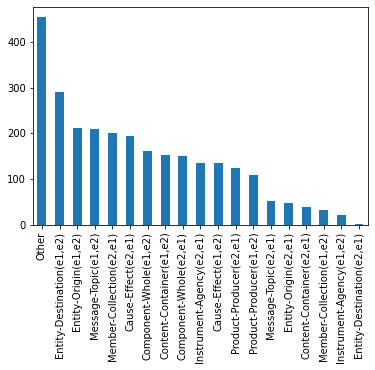

In [7]:
df_test['class'].value_counts()[:27].plot(kind='bar')

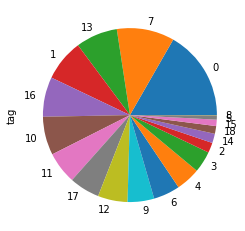

In [8]:
df_test['tag'].value_counts()[:27].plot(kind='pie')

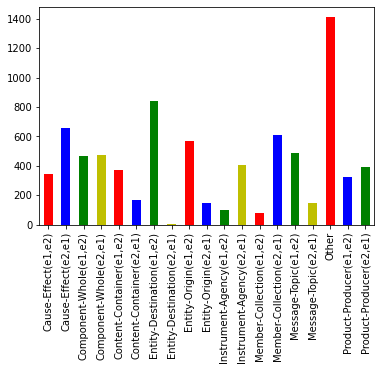

In [9]:
df['class'].value_counts().sort_index().plot.bar(color = {"r","g","b","y"})

# Preprocesssing

Data preprocessor

In [10]:
def preprocessor(sentence):
    
    sentence = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'\d+','', sentence)
    sentence = sentence.replace("user", "")
    return  sentence

In [11]:
def clean_text(df):
   
    train_cleaned = df['sentence'].apply(preprocessor)
    df['sentence'] = train_cleaned.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
  
    return df    

In [12]:
#cleaning the text
df['sentence'] = df['sentence'] + " " + df['element1'] + " " + df['element2']
df_test['sentence'] = df_test['sentence'] + " " + df_test['element1'] + " " + df_test['element2']
train_cleaned = clean_text(df)
test_cleaned = clean_text(df_test)

GPU tracker

In [13]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


# Install Transformers

In [14]:
pip install transformers

     |████████████████████████████████| 2.6 MB 5.4 MB/s 
     |████████████████████████████████| 636 kB 47.7 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Bert Transformer

In [15]:
from transformers import BertTokenizer

# loading BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#  tokenizing set of texts
def Input_embeddings(data,length):
  
    input_ids = []
    attention_masks = []

    for sentence in data:
   
        encoded_sent = tokenizer.encode_plus(
            text=sentence,  
            add_special_tokens=True,        
            max_length=length,              
            pad_to_max_length=True,                  
            return_attention_mask=True      
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encoding and tokenizing the sencentences

In [16]:
sentences = np.concatenate([train_cleaned.sentence.values, test_cleaned.sentence.values])
sentences_encoded = [tokenizer.encode(sent, add_special_tokens=True, truncation=True) for sent in sentences]
max_length = max([len(sent) for sent in sentences_encoded])
print('Max length: ', max_length)

Max length:  99


Sample token id for the original sentences

In [17]:
data = [train_cleaned.sentence[0]]
token_ids = list(Input_embeddings(data,max_length)[0].squeeze().numpy())
print('Original: ', train_cleaned.sentence[0])
print('Token IDs: ', token_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  the system described above has its greatest application arrayed configuration antenna elements configuration elements
Token IDs:  [101, 1996, 2291, 2649, 2682, 2038, 2049, 4602, 4646, 9140, 2098, 9563, 13438, 3787, 9563, 3787, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Train and validation inputs for the Bert classifier

In [18]:
train_inputs, train_masks = Input_embeddings(train_cleaned.sentence.values,max_length)
val_inputs, val_masks = Input_embeddings(test_cleaned.sentence.values,max_length)

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(train_cleaned['tag'])
val_labels = torch.tensor(test_cleaned['tag'])

batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [20]:
# this piece of code is refered from https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
%%time
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, freeze_bert=True):

        super(BertClassifier, self).__init__()
        inlet, outlet, b_out  = 768, 50, 19

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            #nn.Dropout(0.1),
            nn.Linear(inlet, outlet),
            nn.ReLU6(),
            nn.Linear(outlet, b_out)
        )
#This code is used for fine tuning purposes
        # if freeze_bert:
        #     for param in self.bert.parameters():
        #         param.requires_grad = True
        for layer in self.bert.encoder.layer[:-6]:
          for param in layer.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 7.18 ms, sys: 921 µs, total: 8.1 ms
Wall time: 7.94 ms


# Classifier

In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

def model_initialize(epochs=4):

    bert_classifier = BertClassifier()

    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-4,    
                      eps=1e-8   
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Experimental setup and Evaluation

In [22]:
import random
import time
from sklearn.metrics import f1_score

loss_fn = nn.CrossEntropyLoss()

def seed_set(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        #header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val F1_score':^9} | {'Elapsed':^9}")
        print("-"*70)
  #measuring elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
       #Reseting the  variables at the beginning of every epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
       #training mode
        model.train()      
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            #Loading batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

           # Zero out any previously calculated gradients
            model.zero_grad()

            #Performing a forward pass
            logits = model(b_input_ids, b_attn_mask)

           # Computing loss
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

             # Performing a backward pass
            loss.backward()

            #to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Updating parameters and the learning rate
            optimizer.step()
            scheduler.step()

            
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                
                time_elapsed = time.time() - t0_batch

                # Printing training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

  
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

      
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        if evaluation == True:
            val_loss, val_f1score = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_f1score:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):  
    model.eval()
    val_f1score = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)      
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())      
        preds = torch.argmax(logits, dim=1).flatten()       
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        f1score = f1_score(b_labels.tolist(),preds.tolist(),average = 'macro')
        val_f1score.append(f1score)


    val_loss = np.mean(val_loss)
    val_f1score = np.mean(val_f1score)

    return val_loss, val_f1score

In [23]:
seed_set(45)    # seed for reproducibility
bert_classifier, optimizer, scheduler = model_initialize(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  | Val F1_score |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   2.649142   |     -      |     -     |   34.20  
   1    |   40    |   2.026215   |     -      |     -     |   32.95  
   1    |   60    |   1.615663   |     -      |     -     |   32.95  
   1    |   80    |   1.366890   |     -      |     -     |   32.90  
   1    |   100   |   1.230829   |     -      |     -     |   32.87  
   1    |   120   |   1.092760   |     -      |     -     |   32.80  
   1    |   124   |   0.987648   |     -      |     -     |   6.57   
----------------------------------------------------------------------
   1    |    -    |   1.649838   |  0.946946  |   0.65    |  236.33  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  | Val F1_score |  Elapsed 
------------------------------------------------------------

# Naive Bayes and svm 

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [25]:
import random
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV



datastr=df['sentence'].astype(str)
test_datastr=df_test['sentence'].astype(str)
count_vector = CountVectorizer()
train_counts = count_vector.fit_transform(datastr)
print (train_counts.shape)

(8000, 19048)


In [26]:
df=load_data_label(path_to_file)
df_test = load_data_label(path_to_test_file)
train_cleaned = clean_text(df)
test_cleaned = clean_text(df_test)
df['sentence'] = df['sentence'] + " " + df['element1'] + " " + df['element2']
df_test['sentence'] = df_test['sentence'] + " " + df_test['element1'] + " " + df_test['element2']

In [27]:
tf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
tf_train = tf_transformer.transform(train_counts)
print (tf_train.shape)

(8000, 19048)


In [28]:
#It is reffered from http://analyticmunch.weebly.com/semeval-2010-task-8.html

tf_idf_transformer = TfidfTransformer()
tf_idf_train = tf_idf_transformer.fit_transform(train_counts)
print (tf_idf_train.shape)

(8000, 19048)


In [29]:
data_component_numeric = df['tag'].values

# Naive bayes classifier

In [30]:
multi_nb = MultinomialNB().fit(tf_idf_train, data_component_numeric)

In [31]:
text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))),
    ('tfidftransformer', TfidfTransformer(use_idf=True)),
    ('classification', MultinomialNB(alpha=0.01)),])
text_classification = text_classification.fit(datastr, data_component_numeric)
predicted = text_classification.predict(test_datastr)

In [32]:
test_keys_numeric = df_test['tag'].values
accuracy_for_test_keys = np.mean(predicted == test_keys_numeric)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

Multinomial Naive Bayes Model Accuracy = 51.93227824806772 %


# Grid search

In [33]:
parameters = {'vectorizer__ngram_range': [(1, 3), (1, 3),(1,5)],'tfidftransformer__use_idf': (True, False),
'classification__alpha': (1e-2, 1e-3),'vectorizer__stop_words':('english',None)}

gs_clf = GridSearchCV(text_classification, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(datastr, data_component_numeric)
print (gs_clf.best_score_)
print (gs_clf.best_params_)

0.47962499999999997
{'classification__alpha': 0.01, 'tfidftransformer__use_idf': False, 'vectorizer__ngram_range': (1, 3), 'vectorizer__stop_words': None}


# svm Classification

In [34]:
text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))),
    ('tfidftransformer', TfidfTransformer(use_idf=False)),
    ('classification', SGDClassifier(loss='squared_hinge',penalty='l2',alpha=4*1e-4, random_state=50,eta0=0.0009)),])

In [35]:
roop = text_classification.fit(datastr, data_component_numeric)
svm_prediction = text_classification.predict(test_datastr)

In [36]:
svm_accuracy = np.mean(svm_prediction == test_keys_numeric)
print("Support Vector Machine Model Accuracy={} %".format(svm_accuracy*100))


Support Vector Machine Model Accuracy=54.913507545086496 %
